In [1]:
using Agents, Plots, LightGraphs, GraphRecipes, MetaGraphs, Random
include("src/warehouse.jl")
include("src/highway.jl");

# Init Warehouse

In [2]:
m,n = 3,3
g,p,d = generate_warehouse_struct(m,n,d_start=2,graph_type=SimpleDiGraph)

({49, 48} directed simple Int64 graph, [1.0 1.0; 1.0 2.0; … ; 7.0 6.0; 7.0 7.0], [30, 32, 34, 44, 46, 48])

In [3]:
factor = 2
function init_warehouse(;n_packages=10)
    Random.seed!(1234)

    ## Simulation 
    n_packages = 10
    load_spots = [8,12]
    package_list = rand(1:length(d),n_packages);

    warehouse_space = GraphSpace(g)
    model_props = Dict(:package_list=>package_list,
    :load_spot=>load_spots,
    :last_spot=> length(load_spots),
    :dest_spot=>d,
    :graph => g,
    :step => 1,
    :check_next_step => true,
    :used_load_spots=>zeros(Int,(length(load_spots))))

    warehouse = ABM(Robot, warehouse_space;properties= model_props)

    add_agent!(Robot(1,2,0,1,[]),2, warehouse)
    add_agent!(Robot(2,6,0,1,[]),6, warehouse)
    return warehouse, model_props
end

init_warehouse (generic function with 1 method)

In [4]:
warehouse, model_props = init_warehouse();
display(warehouse.properties)


dest_spot_grid = model_props[:dest_spot].-(2*n+1)

robot_colors = (x,y)-> robot_colors_spots(x,y,model_props[:load_spot],dest_spot_grid)
robot_sizes = (x,y,z) -> robot_sizes_spots(x,y,z,model_props[:load_spot],model_props[:dest_spot],dest_spot_grid,factor)

cs=fill(0.05, nv(g), nv(g));

plot_warehouse = ()-> plotabm(warehouse;am=(x,y)->:rect,as=robot_sizes,ac=robot_colors,x=p[:,2],y=p[:,1],curves=false,curvature_scalar=cs,size=(750,750),linealpha=0.5,markerstrokewidth=0.0,arrow=true);
pl(model) = Vector(model.package_list);
adata = [:pos, :dest,:head]
mdata =[:last_spot,pl];

Dict{Symbol, Any} with 8 entries:
  :load_spot       => [8, 12]
  :graph           => {49, 48} directed simple Int64 graph
  :last_spot       => 2
  :step            => 1
  :used_load_spots => [0, 0]
  :package_list    => [3, 4, 6, 4, 1, 3, 6, 1, 1, 5]
  :dest_spot       => [30, 32, 34, 44, 46, 48]
  :check_next_step => true

# Init nowait

In [5]:
function robot_step_highway_nowait!(robot,model)
    
    move_now = true    
#     println(model.step)
    # if isempty(nearby_ids(robot,model))
    # if !(robot.dest in [robot.pos for robot in nearby_agents(robot,model)])
    
    if robot_in_destination(robot,model)
        robot.dest = 0        
    end
    
    if robot.dest == 0        
        give_robot_destination(robot,model)                                                     
    end
    
    if isempty(model.package_list) & (robot.pos in model.load_spot) & (robot.dest in model.load_spot)
        move_now=false
    end
    
      
            
    if move_now == true #& ~isempty(robot.path)
        if isempty(robot.path) & (robot.dest != 0 )
            robot.path = a_star(model.graph,robot.pos,robot.dest)
        end
        if !isempty(robot.path)
#             print("Hejbu se")
            next_step = robot.path[1].dst
            # next_step = popfirst!(robot.path).dst
            # pos = robot.pos
            if !(next_step in [robot.pos for robot in nearby_agents(robot,model)])
                move_agent!(robot,next_step,model)
                popfirst!(robot.path)
            end
        end
    end            
    
end          


robot_step_nowait! (generic function with 1 method)

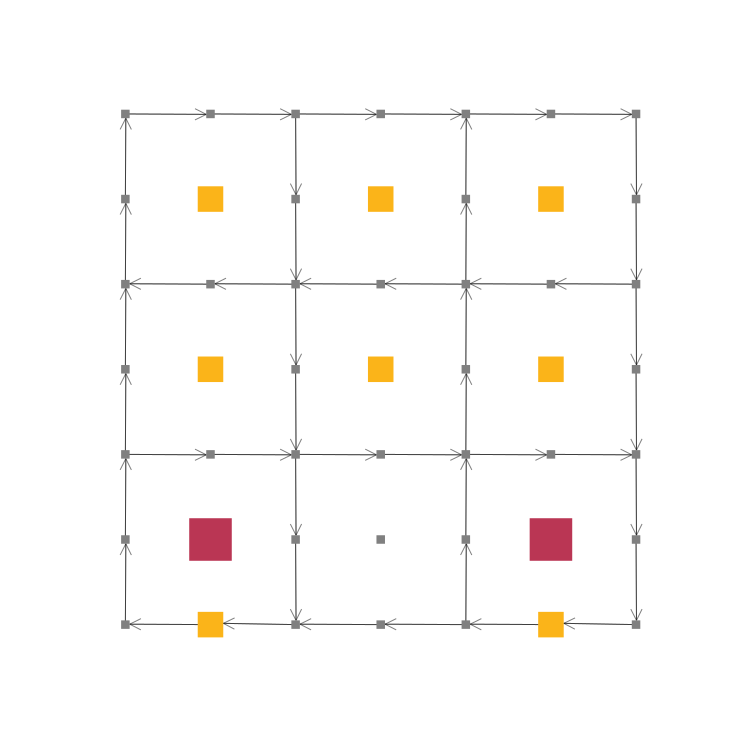

In [6]:
plot_warehouse()

# RUN

In [12]:
warehouse,_ = init_warehouse()
adf, mdf = run!(warehouse, robot_step_nowait!,warehouse_step!,terminate_warehouse_sim; 
    adata=adata,mdata=mdata,agents_first=true)
warehouse.step

124

In [16]:
display(adf[end-20:end,:])

,step,id,pos,dest,head
,Int64,Int64,Int64,Int64,Int64
1,113,2,29,8,1
2,114,1,32,46,1
3,114,2,36,8,1
4,115,1,31,46,1
5,115,2,43,8,1
6,116,1,30,46,1
7,116,2,44,8,1
8,117,1,29,46,1
9,117,2,45,8,1


In [9]:
warehouse,_ = init_warehouse()
n_agents = nagents(warehouse)
display(warehouse.properties)
anim = @animate for i in 0:500
    # p1 = plotabm(warehouse;am=(x,y)->:circle,as=robot_sizes,ac=robot_colors,x=p[:,2],y=p[:,1],curves=false,arrow=true,curvature_scalar=cs,size=(1000,1000))
#     p1 = plotabm(warehouse;am=(x,y)->:rect,as=robot_sizes,ac=robot_colors,x=p[:,2],y=p[:,1],curves=false,arrow=false,curvature_scalar=cs,size=(2000,2000),linealpha=0.5,markerstrokewidth=0.0)
    p1 = plot_warehouse()
#     display(i)    
    title!(p1, "step:$(i),packages to dispatch:$(length(warehouse.properties[:package_list]))")
    if terminate_warehouse_sim(warehouse,i)
        # gif(anim, "warehouse_$(m)_$(n)_$(n_agents).mp4", fps = 4)
        break
    end
    step!(warehouse, robot_step_nowait!,warehouse_step!, 1,true)
end
gif(anim, "nowait_warehouse_$(m)_$(n)_$(n_agents).mp4", fps = 4);

Dict{Symbol, Any} with 8 entries:
  :load_spot       => [8, 12]
  :graph           => {49, 48} directed simple Int64 graph
  :last_spot       => 2
  :step            => 1
  :used_load_spots => [0, 0]
  :package_list    => [3, 4, 6, 4, 1, 3, 6, 1, 1, 5]
  :dest_spot       => [30, 32, 34, 44, 46, 48]
  :check_next_step => true

0

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

51

52

53

54

55

56

57

58

59

60

61

62

63

64

65

66

67

68

69

70

71

72

73

74

75

76

77

78

79

80

81

82

83

84

85

86

87

88

89

90

91

92

93

94

95

96

97

98

99

100

101

102

103

104

105

106

107

108

109

110

111

112

113

114

115

116

117

118

119

120

121

122

123

┌ Info: Saved animation to 
│   fn = /home/datalab/projects/agents/warehouse/nowait_warehouse_3_3_2.mp4
└ @ Plots /home/datalab/.julia/packages/Plots/oZheM/src/animation.jl:104


In [10]:
warehouse.step

124